__NOTE:__ This notebook explores implementing VAE on Celeb A dataset. Instead of Relu, leaky relu is used for activation since relu might lead to 0 gradients and might lead to stopping the training. Also Batch Norm is used for stabilised training

Dataset Reference: https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html

      @inproceedings{liu2015faceattributes,

      title = {Deep Learning Face Attributes in the Wild},

      author = {Liu, Ziwei and Luo, Ping and Wang, Xiaogang and Tang, Xiaoou},

      booktitle = {Proceedings of International Conference on Computer Vision (ICCV)},

      month = {December},

      year = {2015} 
      
      }

# Importing Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch import optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from torchsummary import summary
from PIL import Image
import pandas as pd
import pathlib
import wandb
import re
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Helper Functions

In [2]:
def save_checkpoint(model, save_path):
    torch.save(model.state_dict(), save_path)
    
def load_checkpoint(model, save_path):
    model.load_state_dict(torch.load(save_path))
    return model

def visualization(dataloader, model, title, clear = True):
    model.eval()
    sigmoid = nn.Sigmoid()
    fig_1, axes_1 = plt.subplots(nrows = 10, ncols = 10, figsize = (6,6))
    fig_2, axes_2 = plt.subplots(nrows = 10, ncols = 10, figsize = (6,6))
    i = 0
    with torch.no_grad():
        pbar = tqdm(dataloader, total = len(dataloader), leave = False)
        for imgs, _ in pbar:
            imgs = imgs.to(device)
            _, _, _, reconstructed = model(imgs)
            out = sigmoid(reconstructed)
            if i<100:
                for idx in range(len(out)):
                    img = np.transpose(imgs[idx].detach().cpu().numpy(), (1,2,0))
                    out_img = np.transpose(out[idx].detach().cpu().numpy(), (1,2,0))
                    axes_1[i//10, i%10].imshow(img)
                    axes_1[i//10, i%10].axis('off')
                    axes_2[i//10, i%10].imshow(out_img)
                    axes_2[i//10, i%10].axis('off')
                    i+=1
                    if i==100:
                        break
            if i>=100:
                break
    wandb.log({f"{title}_original": fig_1, f"{title}_regenerated":fig_2})
    if clear:
        fig_1.clear()
        plt.close(fig_1)
        fig_2.clear()
        plt.close(fig_2)

def KL_divergence(latent_mean, latent_log_var):
    example_divergence = torch.sum(-0.5*(1 + latent_log_var - torch.square(latent_mean) - torch.exp(latent_log_var)), dim = -1)
    batch_divergence = torch.mean(example_divergence)
    return batch_divergence

# Hyperparameters

In [ ]:
batch_size = 64
input_vector_channel = 3
img_resize = 64
img_crop_size = 64
img_aug_p = 0.4
rotation = 15
# Setting experiment
wandb.init(dir = 'logs/', project='GAN Projects', name="CNN based VAE (Celeb A)")
num_filters = [32, 64, 128, 256]
latent_dim = 400
filter_size = 3
strides = [2, 2, 2, 2]
learning_rate = 1e-03
num_epochs = 50
reconstruct_weight = 2000
criterion = nn.BCEWithLogitsLoss()
valid_size = 0.2
save_path = './saved_models/vae_cnn_celeba.pt'

wandb.config = {
    'batch_size': batch_size,
    'num_filters': num_filters,
    'latent_dim': latent_dim,
    'image_size': img_crop_size,
    'valid_size': valid_size,
    'filter_size': filter_size,
    'img_aug_p': img_aug_p,
    'strides': strides,
    'learning_rate': learning_rate,
    'num_epochs': num_epochs,
    'reconstruct_weight': reconstruct_weight,
    'initializer': 'glorot_uniform',
    'loss': 'bce_logits + kl_divergence'
}

# Loading and preprocessing data

In [4]:
class CelebADataset(Dataset):
    def __init__(self, images_path, transforms = None):
        self.images_path = images_path
        self.transforms = transforms
    def __len__(self):
        return len(self.images_path)
    def __getitem__(self, idx):
        img_path = self.images_path[idx]
        img = Image.open(str(img_path))
        fname = img_path.name
        if self.transforms:
            img = self.transforms(img)
        return img, fname

In [5]:
base_path = pathlib.Path('data/celeba/')
imgs_dir = base_path/'images/images'
all_images = list(imgs_dir.glob('./*.png'))
num_valid = int(valid_size*len(all_images))
train_imgs = all_images[num_valid:]
valid_imgs = all_images[:num_valid]
print(f'Total Number of Images: {len(all_images)}')
print(f'Total Number of Train Images: {len(train_imgs)}')
print(f'Total Number of Valid Images: {len(valid_imgs)}')

Total Number of Images: 202599
Total Number of Train Images: 162080
Total Number of Valid Images: 40519


In [6]:
transform = transforms.Compose([transforms.Resize(img_resize),
                                transforms.RandomCrop(img_crop_size, pad_if_needed=True),
                                transforms.RandomHorizontalFlip(p = img_aug_p),
                                transforms.RandomRotation(degrees=rotation),
                                transforms.ToTensor()])
train_dataset = CelebADataset(train_imgs,transforms = transform)
valid_dataset = CelebADataset(valid_imgs,transforms = transform)
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle = True, num_workers=8, pin_memory=True)
validloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle = True, num_workers=8, pin_memory=True)

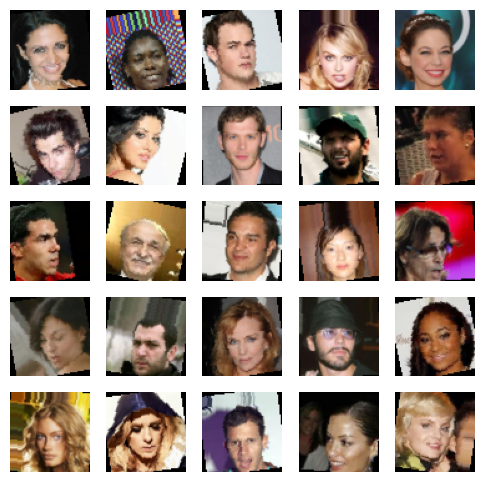

In [7]:
# Visualizing Data
imgs, _ = next(iter(trainloader))
imgs.shape
rows, cols = 5, 5
fig, axes = plt.subplots(rows, cols, figsize = (6,6))
i = 0
for idx in range(rows*cols):
    img = np.transpose(imgs[idx].detach().cpu().numpy(), (1, 2, 0))
    axes[i//rows, i%cols].imshow(img)
    axes[i//rows, i%cols].axis('off')
    i+=1

# Autoencoder

In [8]:
# For sampling from given latent_mean and latent_log_var which is used for generation of image
# (This is done for reparamaterization trick introduced in the paper)
class SamplingLayer(nn.Module):
    def __init__(self, latent_dim):
        super(SamplingLayer, self).__init__()
        self.latent_dim = latent_dim

    def forward(self, latent_mean, latent_log_var):
        batch_size = latent_mean.shape[0]
        eps = torch.randn((batch_size, self.latent_dim), device = latent_mean.device)
        return latent_mean + torch.exp(0.5*latent_log_var)*eps

class CNNAutoEncoder(nn.Module):
    def __init__(self, input_vector_channel, num_filters, latent_dim, strides, leaky_relu_slope = 0.3):
        super(CNNAutoEncoder, self).__init__()

        enc_list = []
        dec_list = []
        self.inp_dim = input_vector_channel[0]
        all_units = input_vector_channel + num_filters

        # Encoder
        for i in range(len(all_units) - 1):
            temp = [nn.Conv2d(all_units[i], all_units[i+1], 3, strides[i], padding=1),
                    nn.BatchNorm2d(all_units[i+1]),
                    nn.LeakyReLU(leaky_relu_slope, inplace = True)]
            enc_list.extend(temp)

        # Calculated from hand or can run torchsummary once to check dimensions
        self.shape_before_flatten = np.array([256, 4, 4])
        enc_list.append(nn.Flatten())
        self.encoder = nn.Sequential(*enc_list)

        self.mean_layer = nn.Linear(np.prod(self.shape_before_flatten), latent_dim)
        self.var_layer =  nn.Linear(np.prod(self.shape_before_flatten), latent_dim)
        self.sample_layer = SamplingLayer(latent_dim)
        self.bottleneck = nn.Linear(latent_dim, np.prod(self.shape_before_flatten))

        
        # Decoder
        
        for i in range(len(all_units) - 1, 1, -1):
            temp = [nn.ConvTranspose2d(all_units[i], all_units[i-1], 3, strides[i-1], padding = 1, output_padding=1),
                    nn.BatchNorm2d(all_units[i-1]),
                    nn.LeakyReLU(leaky_relu_slope, inplace = True)]
            dec_list.extend(temp)
        dec_list.extend([nn.ConvTranspose2d(all_units[i-1], all_units[i-2], 3, strides[i-2], padding = 1, output_padding=1)])
        self.decoder = nn.Sequential(*dec_list)

        # Initialize weights
        self.encoder.apply(self.init_weights)
        self.decoder.apply(self.init_weights)
        self.bottleneck.apply(self.init_weights)

    def init_weights(self, layer):
        if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
            torch.nn.init.xavier_uniform_(layer.weight)
            layer.bias.data.fill_(0.0)

    def forward(self, x):
        out = self.encoder(x)
        latent_mean = self.mean_layer(out)
        latent_log_var = self.var_layer(out)
        latent_embed = self.sample_layer(latent_mean, latent_log_var)
        out = self.bottleneck(latent_embed)
        out = out.view(-1, *self.shape_before_flatten)
        out = self.decoder(out)
        return latent_mean, latent_log_var, latent_embed, out

In [10]:
cnn_autoencoder = CNNAutoEncoder([input_vector_channel], num_filters, latent_dim, strides)
summary(cnn_autoencoder, (3, 64, 64));

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 4096]                --
|    └─Conv2d: 2-1                       [-1, 32, 32, 32]          896
|    └─BatchNorm2d: 2-2                  [-1, 32, 32, 32]          64
|    └─LeakyReLU: 2-3                    [-1, 32, 32, 32]          --
|    └─Conv2d: 2-4                       [-1, 64, 16, 16]          18,496
|    └─BatchNorm2d: 2-5                  [-1, 64, 16, 16]          128
|    └─LeakyReLU: 2-6                    [-1, 64, 16, 16]          --
|    └─Conv2d: 2-7                       [-1, 128, 8, 8]           73,856
|    └─BatchNorm2d: 2-8                  [-1, 128, 8, 8]           256
|    └─LeakyReLU: 2-9                    [-1, 128, 8, 8]           --
|    └─Conv2d: 2-10                      [-1, 256, 4, 4]           295,168
|    └─BatchNorm2d: 2-11                 [-1, 256, 4, 4]           512
|    └─LeakyReLU: 2-12                   [-1, 256, 4, 4]           -

In [11]:
visualization(trainloader, cnn_autoencoder, "Pre_Train", clear = True)
visualization(validloader, cnn_autoencoder, "Pre_valid", clear = True);

# Training Autoencoder



In [12]:
def train_batch(imgs, model, criterion, optimizer, scaler, reconst_weight = 500, valid = False):
    optimizer.zero_grad()
    imgs, model = imgs.to(device, non_blocking = True), model.to(device)
    with torch.cuda.amp.autocast():
        z_mean, z_log_var, embed, out = model(imgs)
        batch_loss = criterion(out, imgs)*reconst_weight + KL_divergence(z_mean, z_log_var)
    if not valid:
        scaler.scale(batch_loss).backward()
        scaler.step(optimizer)
        scaler.update()
    return batch_loss.item()

def train(trainloader, validloader, model, criterion, optimizer, num_epochs, load_check = False, best_valid_metric = 0.0, 
          reconst_weight = 500, save_path = './saved_models/checkpoint.pt'):    
    # Load From checkpoint
    if load_check:
        model = load_checkpoint(model, save_path)

    scaler = torch.cuda.amp.GradScaler()
    train_losses, valid_losses = [], []
    for epoch in range(num_epochs+1):
        batch_loss = 0.0
        model.train()
        pbar = tqdm(trainloader, total = len(trainloader), leave = False)
        for imgs, _ in pbar:
            imgs = imgs.to(torch.float32)
            current_batch_loss = train_batch(imgs, model, criterion, optimizer, scaler, reconst_weight)
            batch_loss += current_batch_loss
            pbar.set_postfix(train_loss = current_batch_loss)

        epoch_train_loss = batch_loss / len(trainloader)
        train_losses.append(epoch_train_loss)

        # Calculating for Valid data
        batch_loss = 0.0
        model.eval()
        pbar = tqdm(validloader, total = len(validloader), leave = False)
        with torch.no_grad():
            for imgs, _ in pbar:
                imgs = imgs.to(torch.float32)
                current_batch_loss = train_batch(imgs, model, criterion, optimizer, scaler, reconst_weight, valid = True)
                batch_loss += current_batch_loss
                pbar.set_postfix(valid_loss = current_batch_loss)

        epoch_valid_loss = batch_loss / len(validloader)
        valid_losses.append(epoch_valid_loss)
        
        # Checkpoint
        if epoch_valid_loss < best_valid_metric:
            print('#### Saving ####')
            save_checkpoint(model, save_path)
            best_valid_metric = epoch_valid_loss
            
        wandb.log({'epoch':epoch ,'train_loss': epoch_train_loss, 'valid_loss': epoch_valid_loss})
        visualization(trainloader, cnn_autoencoder, "Epoch_train")
        visualization(validloader, cnn_autoencoder, "Epoch_valid")
        print(f"{'*'*10} EPOCH {epoch:2}/{num_epochs} {'*'*10}")
        print(f'''{"#"*33}
Train Loss: {epoch_train_loss:5.3f}
Valid Loss: {epoch_valid_loss:5.3f}
{"#"*33}''')
    return train_losses, valid_losses

In [ ]:
optimizer = optim.Adam(cnn_autoencoder.parameters(), lr = learning_rate)
train_losses, valid_losses = train(trainloader, validloader, cnn_autoencoder, criterion, optimizer, num_epochs, 
                                   best_valid_metric=999999, reconst_weight = reconstruct_weight, save_path=save_path)

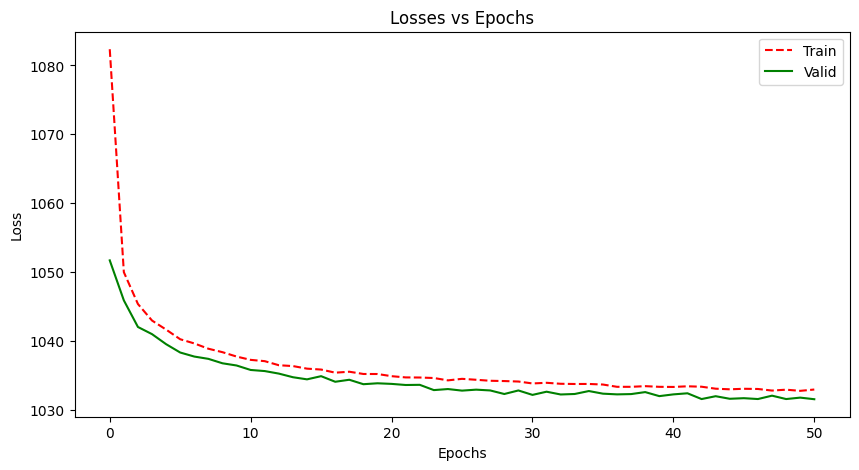

In [14]:
plt.figure(figsize = (10,5))
plt.title('Losses vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(train_losses, 'r--', label = 'Train')
plt.plot(valid_losses, 'g-', label = 'Valid')
plt.legend()
plt.show();

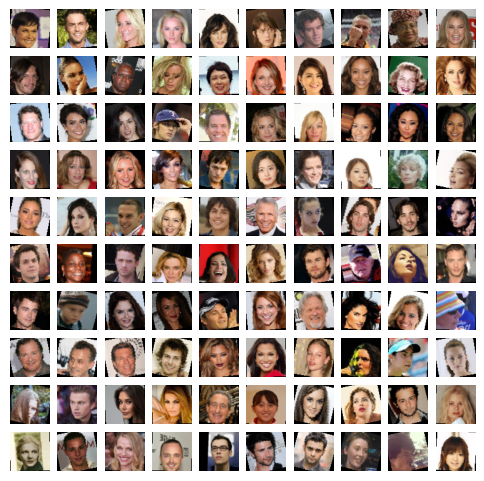

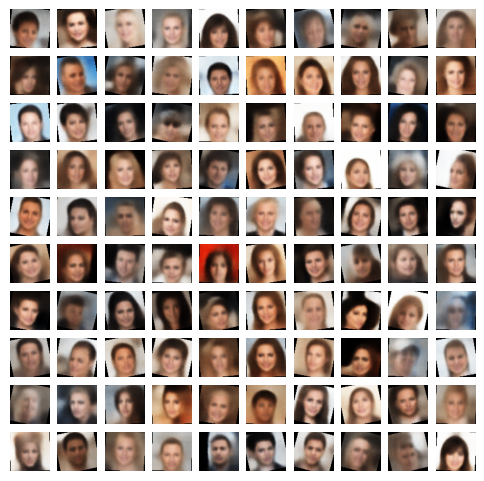

In [15]:
cnn_autoencoder = load_checkpoint(cnn_autoencoder, save_path)
visualization(trainloader, cnn_autoencoder, "Post_train", clear = True)
visualization(validloader, cnn_autoencoder, "Post_valid", clear = False);

# Sampling and results 

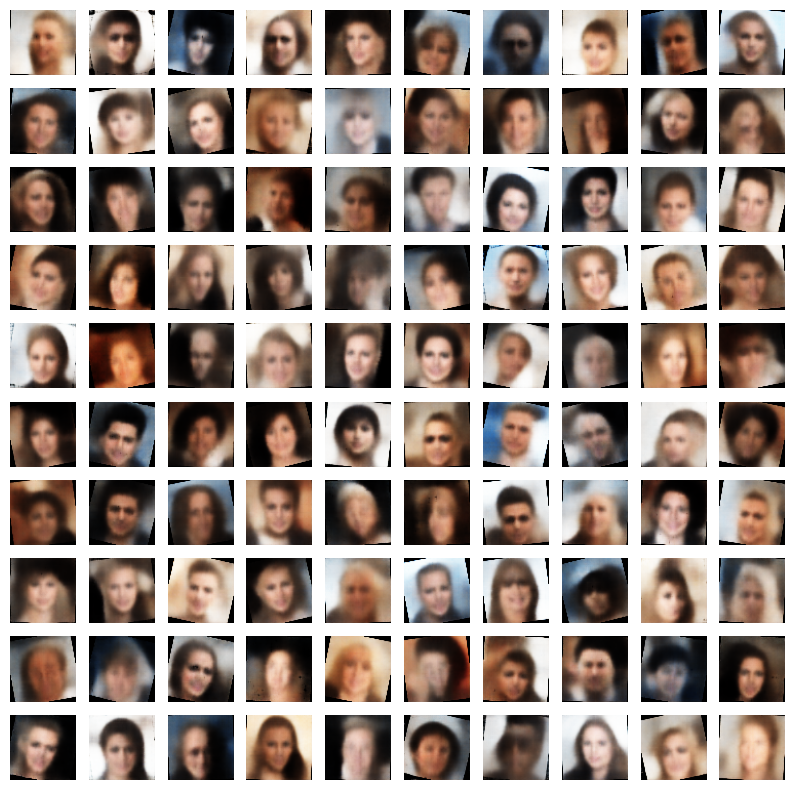

In [16]:
with torch.no_grad():
    cnn_autoencoder.eval()
    # Between 2 standard Deviation
    min, max = -2, 2

    # Setting for plots
    num_images = 100
    nrows = 10
    ncols = num_images // nrows + (num_images % nrows > 0)

    # Sample and Generation
    samples = (max - min)*torch.rand((num_images, latent_dim)) + min
    samples = samples.to(device)
    sigmoid = nn.Sigmoid()
    out = cnn_autoencoder.bottleneck(samples)
    out = out.view(-1, *[256, 4, 4])
    out_images = cnn_autoencoder.decoder(out)
    out_images = sigmoid(out_images)
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        img = out_images[i]
        img = np.transpose(img.detach().cpu().numpy(), (1,2,0))
        plt.subplot(nrows, ncols, i+1)
        plt.imshow(img)
        plt.axis('off')

__NOTE:__ It learns to reconstruct the image from random latent vectors. Not perfect yet working good where some are just distorted

# Morphing between faces

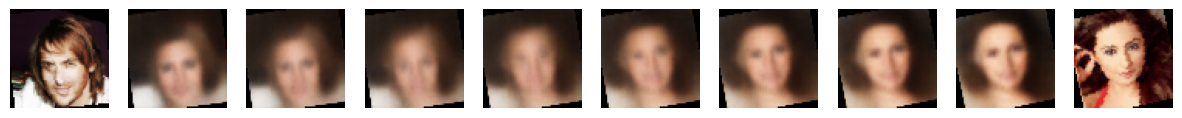

In [17]:
# Pick Two faces
idx_1, idx_2 = 25, 2560
img_1, _ = train_dataset[idx_1]
img_2, _ = train_dataset[idx_2]
parts = 10
alphas = np.linspace(0, 1, parts)
data_inp = torch.cat([img_1[None], img_2[None]]).to(device)
_, _, latent_embed, _ = cnn_autoencoder(data_inp)
latent_a, latent_b = latent_embed[0], latent_embed[1]
i = 0
sigmoid = nn.Sigmoid()
fig, axes = plt.subplots(nrows = 1, ncols = parts, squeeze=True, figsize = (15, 20))
img = np.transpose(img_2.detach().cpu().numpy(), (1,2,0))
axes[i].imshow(img)
axes[i].axis('off')
i+=1
for alpha in alphas[1:-1]:
    current_latent = latent_a*alpha + latent_b*(1-alpha)
    latent_embed = current_latent[None]
    out = cnn_autoencoder.bottleneck(latent_embed)
    out = out.view(-1, *[256, 4, 4])
    out = sigmoid(cnn_autoencoder.decoder(out))
    img = np.transpose(out[0].detach().cpu().numpy(), (1,2,0))
    axes[i].imshow(img)
    axes[i].axis('off')
    i+=1
img = np.transpose(img_1.detach().cpu().numpy(), (1,2,0))
axes[i].imshow(img)
axes[i].axis('off');

__Note:__ In above example a face is morphed into another and it is smooth just using latent dimension

# Latent vector arithmetic

In [18]:
columns = []
complete_data = []
with open(base_path/'list_attr_celeba.txt', 'r') as file:
    for idx, line in enumerate(file.readlines()):
        line = line.strip()
        line = re.sub('\s+', ' ', line)
        data = line.split()
        if idx == 0:
            columns = data
        else:
            complete_data.append(data)
final_data = pd.DataFrame(complete_data, columns=columns)
final_data[columns[1:]] = final_data[columns[1:]].astype('int8')
final_data[columns[0]] = final_data[columns[0]].apply(lambda x: x.replace('.jpg', '.png'))
final_data.head()

,img_name,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.png,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.png,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.png,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.png,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.png,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


Let's try to put glasses on person who is without glasses

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/2/24/Vector_subtraction.svg/1280px-Vector_subtraction.svg.png" style = "height:300px" alt="Image showing vector subtraction">

Vector Subtraction (Source: https://upload.wikimedia.org/wikipedia/commons/thumb/2/24/Vector_subtraction.svg/1280px-Vector_subtraction.svg.png)

Let a be the average vector of with_glass_latent space and b be the average vector of without_glass_latent_space then a - b will move b to a

In [29]:
# Code Reference: https://github.com/davidADSP/Generative_Deep_Learning_2nd_Edition/tree/main
def get_vector_from_label(dataloader, model, embedding_dim, complete_data, label):
    current_sum_POS = np.zeros(shape=embedding_dim, dtype="float32")
    current_n_POS = 0
    current_mean_POS = np.zeros(shape=embedding_dim, dtype="float32")

    current_sum_NEG = np.zeros(shape=embedding_dim, dtype="float32")
    current_n_NEG = 0
    current_mean_NEG = np.zeros(shape=embedding_dim, dtype="float32")

    current_vector = np.zeros(shape=embedding_dim, dtype="float32")
    current_dist = 0

    img_names_with_label = complete_data[complete_data[label] == 1]['img_name'].values.tolist()
    img_names_without_label = complete_data[complete_data[label] == -1]['img_name'].values.tolist()
    for img, img_names in dataloader:
        img = img.to(device)
        _, _, latent_embed, _ = model(img)
        latent_embed = latent_embed.detach().cpu().numpy()
        img_names = np.array(img_names)
        label_idx = np.argwhere(np.isin(img_names, img_names_with_label)).reshape(-1, )
        not_label_idx = np.argwhere(np.isin(img_names, img_names_without_label)).reshape(-1, )
        z_POS = latent_embed[label_idx]
        z_NEG = latent_embed[not_label_idx]

        if len(z_POS) > 0:
            current_sum_POS = current_sum_POS + np.sum(z_POS, axis=0)
            current_n_POS += len(z_POS)
            new_mean_POS = current_sum_POS / current_n_POS
            movement_POS = np.linalg.norm(new_mean_POS - current_mean_POS)

        if len(z_NEG) > 0:
            current_sum_NEG = current_sum_NEG + np.sum(z_NEG, axis=0)
            current_n_NEG += len(z_NEG)
            new_mean_NEG = current_sum_NEG / current_n_NEG
            movement_NEG = np.linalg.norm(new_mean_NEG - current_mean_NEG)

        current_vector = new_mean_POS - new_mean_NEG
        new_dist = np.linalg.norm(current_vector)
        dist_change = new_dist - current_dist

        current_mean_POS = np.copy(new_mean_POS)
        current_mean_NEG = np.copy(new_mean_NEG)
        current_dist = np.copy(new_dist)

        if np.sum([movement_POS, movement_NEG]) < 0.08:
            current_vector = current_vector / current_dist
            break

    return current_vector
change_label = 'Wearing_Hat'
transformation_vector = get_vector_from_label(trainloader, cnn_autoencoder, latent_dim, final_data, change_label)

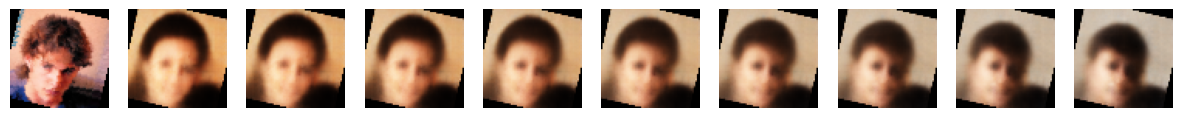

In [30]:
latent_transformation = torch.tensor(transformation_vector).to(device)
# Pick Two faces
idx = 56
img_1, _ = train_dataset[idx]
parts = 10
alphas = np.arange(-5, -5+parts-1, 1)
data_inp = img_1.to(device)[None]
_, _, z_latent, _ = cnn_autoencoder(data_inp)
i = 0
sigmoid = nn.Sigmoid()
fig, axes = plt.subplots(nrows = 1, ncols = parts, squeeze=True, figsize = (15, 20))
img = np.transpose(img_1.detach().cpu().numpy(), (1,2,0))
axes[i].imshow(img)
axes[i].axis('off')
i+=1
for alpha in alphas:
    transformed_latent = z_latent + alpha*latent_transformation
    latent_embed = transformed_latent[None].to(torch.float32)
    out = cnn_autoencoder.bottleneck(latent_embed)
    out = out.view(-1, *[256, 4, 4])
    out = sigmoid(cnn_autoencoder.decoder(out))
    img = np.transpose(out[0].detach().cpu().numpy(), (1,2,0))
    axes[i].imshow(img)
    axes[i].axis('off')
    i+=1